# LSTM Model for Algae Prediction

The following code contains pre-processing code along withe LSTM prediction model.

In [207]:
# pip install scalecast --upgrade

In [208]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns
import pickle
# from scalecast.Forecaster import Forecaster
import time
import os
import re

## Data Pre-Processing

1. Import and combine raw CSV files from sensor. 

1. Perform cross correlation of golay sequences to extract sensor data. 

1. Isolate laser-on sensor readings from laser-off readings.


In [209]:
# defining golay sequences
golay_seq_a = [1,1,1,-1,1,1,-1,1,1,1,1,-1,-1,-1,1,-1,1,1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1, 1]
golay_seq_b = [1,1,1,-1,1,1,-1,1,1,1,1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,-1,1,1,1,-1,-1,-1,1,-1]

def preprocessing(df, start_time_str):
    '''
    takes in the data in the raw time format and processes to the actual datetime
    '''
    #initializing starting time on the file
    start_time = time.strptime(start_time_str, '%Y-%m-%d-%H-%M')
    start_time = time.mktime(start_time) #- 4*60*60
    
    # compute and add col of measurement times in seconds since start time
    df["meas_time"] = df.sec + start_time + (df.day*86400)
    
    # # add a datetime column
    # localized_time = [time.localtime(i) for i in df["meas_time"]]
    df["datetime"] = pd.to_datetime(df["meas_time"], unit='s')
    df["datetime"] = df["datetime"].dt.tz_localize("UTC")
    df["datetime"] = df["datetime"].dt.tz_convert("US/Eastern")
    df = df.drop(df.index[df.name == 'add'])
    df.dropna(inplace=True)
    
    val_mean_ = df["value"].mean() 
    val_std_ = df["value"].std()

    # df["value"] = (df["value"] - val_mean_)/val_std_
    
    return df

def import_folder(folder):
    '''
    Import sensor data from folder.
    '''
    #get sub folders with data and sort by ascending date
    sub_dir = sorted(os.listdir(folder))
    #filter for only valid sub-folders
    files = []
    file_filter = re.compile("[0-3][0-9]_to_[0-2][0-9]_start*")
    for file in sub_dir:
        if file_filter.match(file):
            files.append(file)

    #merge multiple days
    df = pd.DataFrame()
    for file in files:
        path = folder + file + '/' + "GOLAYSEQ.CSV"
        start_time = "20" + folder[-3:-1] + "-" + folder[-6:-4] + "-" + file[:2] + "-" + file[15:17] + "-" + file[18:20]

        df_dum = preprocessing(pd.read_csv(path), start_time)
        df = pd.concat([df, df_dum], ignore_index=True)
    return df

def cross_corr(a, b):
    '''
    takes as input two binary arrays a and b and returns their cross-correlation value
    '''
    a_binary = a - a.mean()
    b_binary = b - b.mean()
    
    xa = np.correlate(a_binary, golay_seq_a, "full")
    xb = np.correlate(b_binary, golay_seq_b, "full")
    
    return xa + xb


def date_plotter(x, y):
    '''
    Wrapper function for plots with dates in the x-axis
    '''
    # Set date format for x-axis labels
    date_fmt = '%m-%d %H:%M'
    # Use DateFormatter to set the data to the correct format.
    date_formatter = mdates.DateFormatter(date_fmt)
    # Use DayLocator to set ticks
    locator =  mdates.WeekdayLocator(byweekday=[3])
    plt.gca().xaxis.set_major_formatter(date_formatter)
    plt.gca().xaxis.set_major_locator(locator)
    for i in y:
        plt.plot(x, i)
    plt.xlabel("Date (Tick Marks for Every Thursday)")
    plt.gcf().autofmt_xdate()


def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')


    

### Importing CSV data

In [210]:
dir = "../data/"

#import feburary and march data
df = import_folder(dir + "02_23/")
df = pd.concat([df, import_folder(dir + "03_23/")])

In [211]:
df.head()

,day,sec,name,value,meas_time,datetime
0,0,601,1,780.0,1.675375e+09,2023-02-02 16:50:01-05:00
1,0,601,1,780.0,1.675375e+09,2023-02-02 16:50:01-05:00
2,0,601,1,780.0,1.675375e+09,2023-02-02 16:50:01-05:00
3,0,601,0,782.0,1.675375e+09,2023-02-02 16:50:01-05:00
4,0,601,1,780.0,1.675375e+09,2023-02-02 16:50:01-05:00


### Computing Cross Correlation

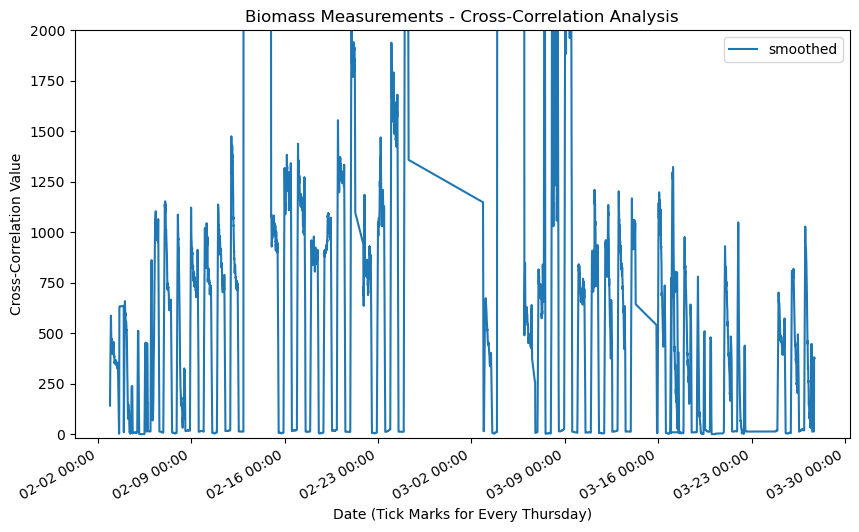

In [212]:


# Compute cross-correlation values for each measurement
#The maximum cross-correlation value for each measurement is stored in the cross_corr_values list
cross_corr_values = []
for meas_time in df.meas_time.unique():
    sub_df = df[df.meas_time == meas_time]
    a = sub_df[:32].value
    b = sub_df[32:].value
    cross_corr_value = cross_corr(a, b)
    cross_corr_values.append(np.max(cross_corr_value)) # Store maximum cross-correlation value

# Smooth output with a moving average
cross_corr_smoothed = moving_average(cross_corr_values, n=12)

# Convert measurement times to seconds since epoch for plotting
measurement_times = mdates.date2num(df.datetime.unique())


# Plot cross-correlation values vs. measurement time
plt.figure(figsize=(10,6))
date_plotter(measurement_times, [cross_corr_smoothed])
plt.legend(['smoothed'])
plt.title("Biomass Measurements - Cross-Correlation Analysis")
plt.ylabel("Cross-Correlation Value")
plt.ylim([-20, 2000])
# plt.savefig("04_29_22/golay.jpg")
plt.show()

## Viewing Raw Night Values

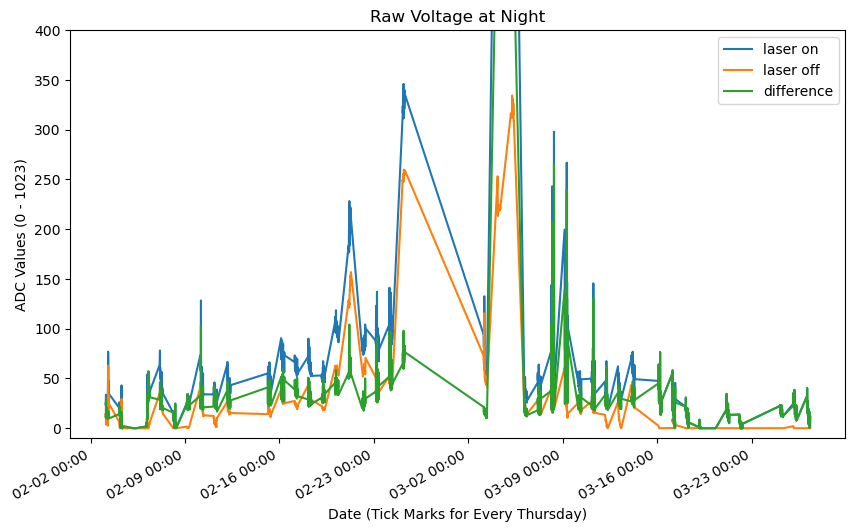

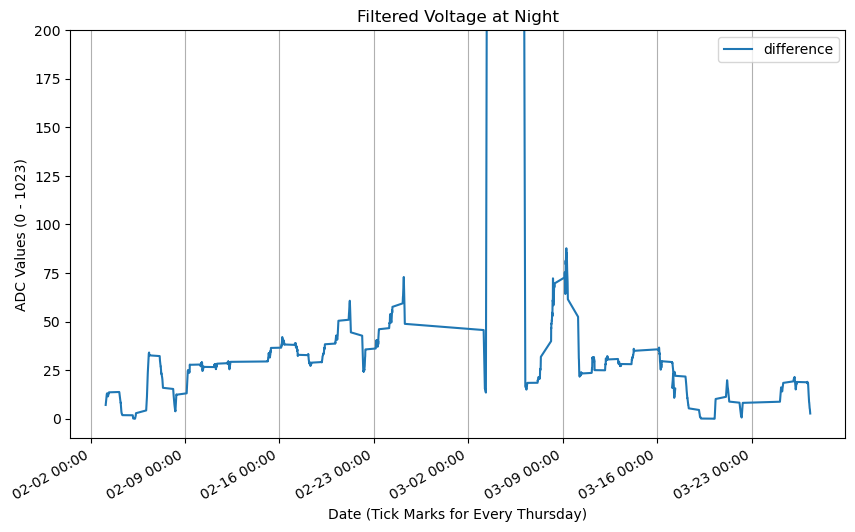

In [213]:
# Filter the data for the night time (10pm to 3am)
night_data = df[(df["datetime"].dt.hour >= 22) | (df["datetime"].dt.hour < 4)].copy()

#create arrays
meas_time = night_data["datetime"].unique()
voltage_on = np.zeros(len(meas_time))
voltage_off = np.zeros(len(meas_time))

# Compute mean ADC measurements for laser on and off measurements as a function of time
for i, t in enumerate(meas_time):
    sub_ndf = night_data[night_data["datetime"] == t]
    voltage_on[i] = sub_ndf["value"][sub_ndf["name"] == "1"].mean()
    voltage_off[i] = sub_ndf["value"][sub_ndf["name"] == "0"].mean()

# Compute difference
voltage_diff = voltage_on - voltage_off

plt.figure(figsize=(10,6))
date_plotter(meas_time, [voltage_on, voltage_off, voltage_diff])
plt.ylim([-10, 400])
plt.title("Raw Voltage at Night")
plt.ylabel("ADC Values (0 - 1023)")
plt.legend(["laser on", "laser off", "difference"])
plt.show()

# Smooth Data
on_avg = moving_average(voltage_on, n=12)
off_avg = moving_average(voltage_off, n=12)
diff_avg = moving_average(voltage_diff, n=24)

plt.figure(figsize=(10,6))
date_plotter(meas_time, [diff_avg])
plt.ylim([-10, 200])
plt.grid(axis='x')
plt.title("Filtered Voltage at Night")
plt.ylabel("ADC Values (0 - 1023)")
plt.legend(["difference"])
plt.show()


# LSTM Modelling for Forecasting

In [51]:
# normalizing the data

val_mean = night_data["value"].mean() 
val_std = night_data['value'].std()

night_data["value"] = (night_data["value"] - val_mean)/val_std

In [52]:
night_data.describe()

,day,sec,value,meas_time
count,47680.000000,47680.000000,4.768000e+04,4.768000e+04
mean,1.115436,27238.610738,6.044272e-14,1.676329e+09
std,0.970772,6480.323014,1.000000e+00,5.956543e+05
min,0.000000,14424.000000,-8.552429e-01,1.675375e+09
25%,0.000000,21636.000000,-5.913199e-01,1.675811e+09
50%,1.000000,27045.000000,-2.187227e-01,1.676419e+09
75%,2.000000,32454.000000,1.849242e-01,1.676855e+09
max,3.000000,42070.000000,5.478909e+00,1.677294e+09


In [53]:
# exploratory data analysis

f = Forecaster(y=night_data['value'],
               current_dates = night_data["datetime"]
)
f

Forecaster(
    DateStartActuals=2023-02-02T22:00:26.000000000
    DateEndActuals=2023-02-25T02:55:58.000000000
    Freq=None
    N_actuals=47680
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

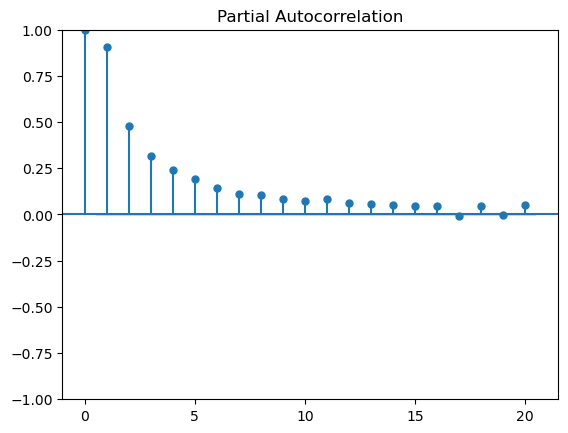

In [63]:
f.plot_pacf(lags=20)
plt.show()

In [57]:
night_data.set_index('datetime')
night_data.dropna(inplace=True)

In [67]:
# LSTM forecasting
# setting test length
f.set_test_length(10000)

# forecasting points
f.generate_future_dates(10000)
f.set_estimator('lstm')

Epoch 1/25
691/691 [==============================] - 26s 33ms/step - loss: 0.0793 - val_loss: 0.0907
Epoch 2/25
691/691 [==============================] - 22s 33ms/step - loss: 0.0764 - val_loss: 0.0947
Epoch 3/25
691/691 [==============================] - 24s 34ms/step - loss: 0.0761 - val_loss: 0.0924
Epoch 4/25
691/691 [==============================] - 23s 34ms/step - loss: 0.0755 - val_loss: 0.0928
Epoch 5/25
691/691 [==============================] - 24s 34ms/step - loss: 0.0748 - val_loss: 0.0922
Epoch 6/25
1/1 [==============================] - 1s 811ms/step
Epoch 1/25
941/941 [==============================] - 34s 32ms/step - loss: 0.0667 - val_loss: 0.0517
Epoch 2/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0636 - val_loss: 0.0543
Epoch 3/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0631 - val_loss: 0.0520
Epoch 4/25
941/941 [==============================] - 30s 32ms/step - loss: 0.0627 - val_loss: 0.0529
Epoch 5/25
941/941

C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Values'>

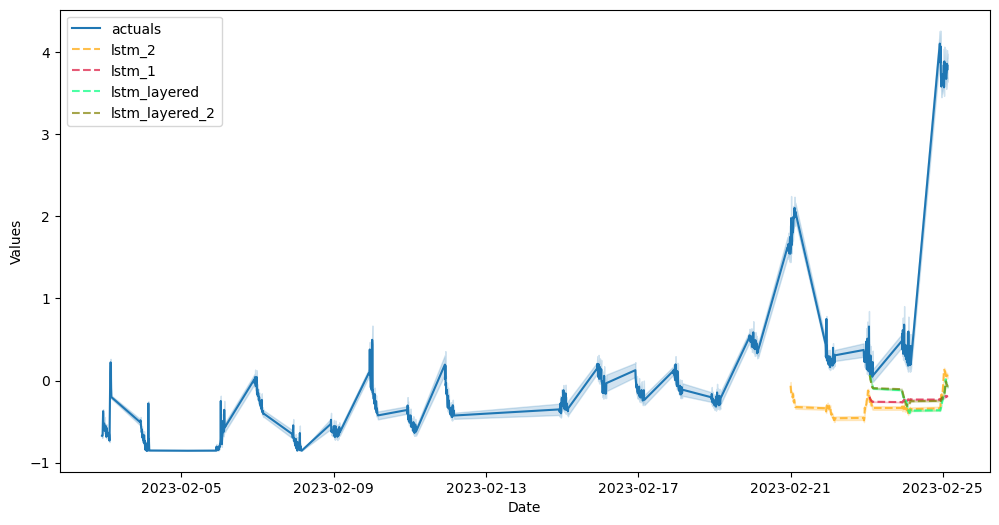

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(call_me = 'lstm_2',
                   lags=40,
                   epochs=25,
                   validation_split=.2,
                   shuffle=True,
                   callbacks=EarlyStopping(
                   monitor='val_loss',
                   patience=5),
                   lstm_layer_sizes=(64,32,32),
                  dropout=(0,0,0)
                  
                   )
f.plot_test_set(ci=True)


1178/1178 [==============================] - 4s 3ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<AxesSubplot:xlabel='Date', ylabel='Values'>

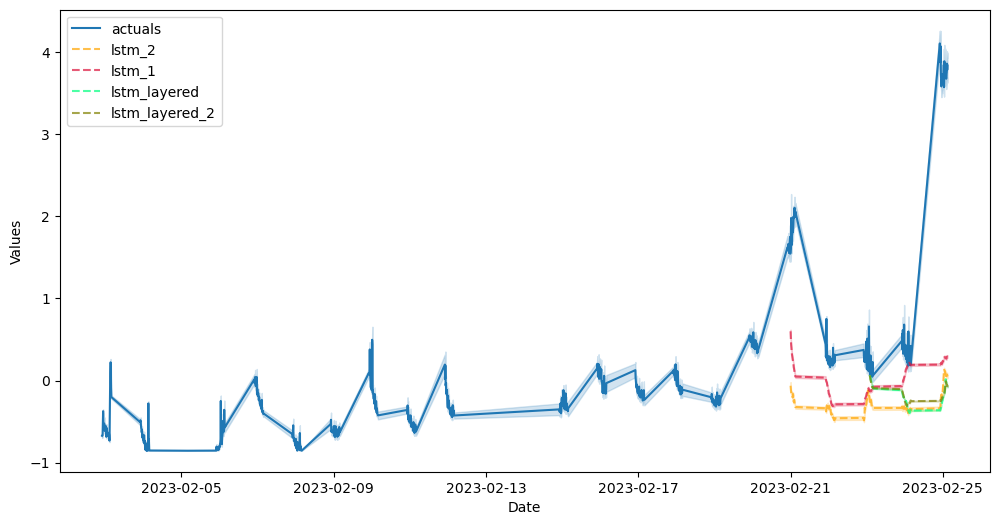

In [69]:
f.manual_forecast(call_me='lstm_1')
f.plot_test_set(ci=True)

1/1 [==============================] - 0s 297ms/step


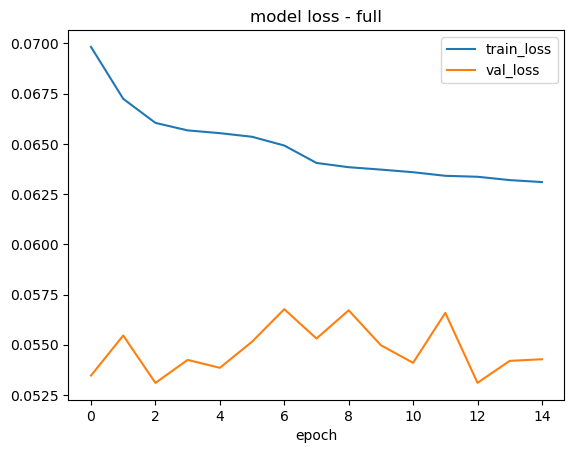

1174/1174 [==============================] - 9s 8ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


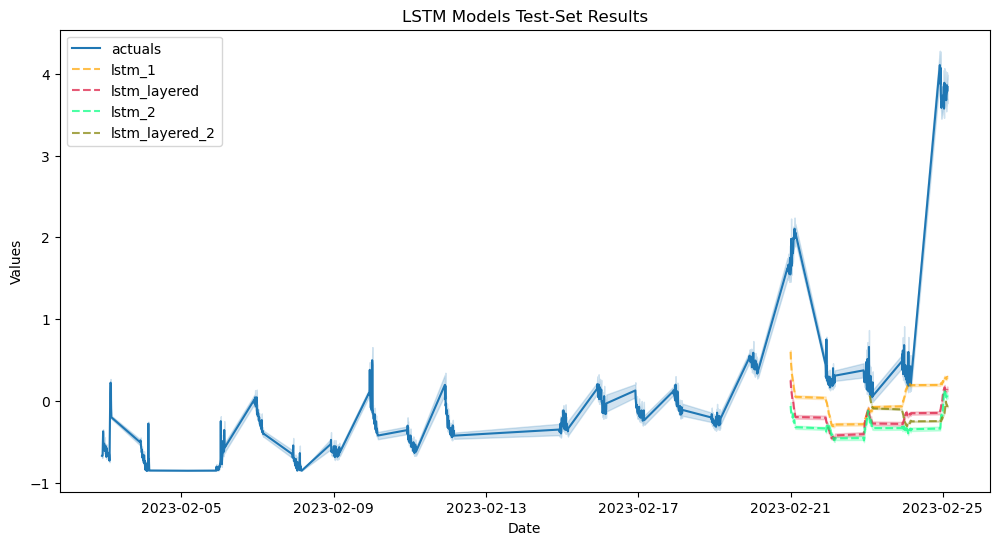

In [70]:
f.manual_forecast(
    lags=120,
    layers_struct=[('LSTM',{'units':100,'dropout':0})]*2 + [('Dense',{'units':10})]*2,
    epochs=15,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='lstm_layered',
    verbose=0
)
f.plot_test_set(ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results')
plt.show()

1/1 [==============================] - 0s 312ms/step


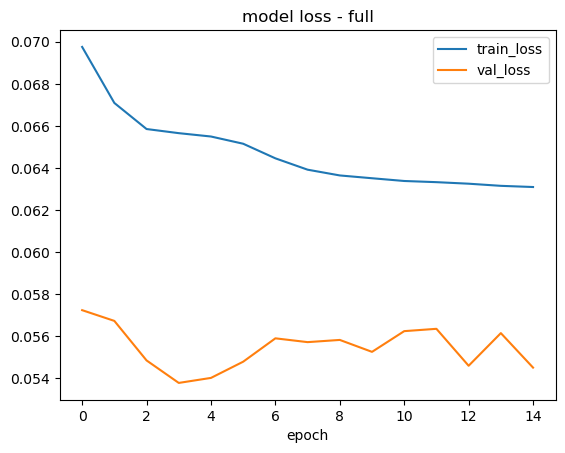

1176/1176 [==============================] - 4s 3ms/step


C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_1. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_layered. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
C:\Users\local_admin\anaconda3\lib\site-packages\scalecast\_utils.py:55: Warning: Confidence intervals not found for lstm_2. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


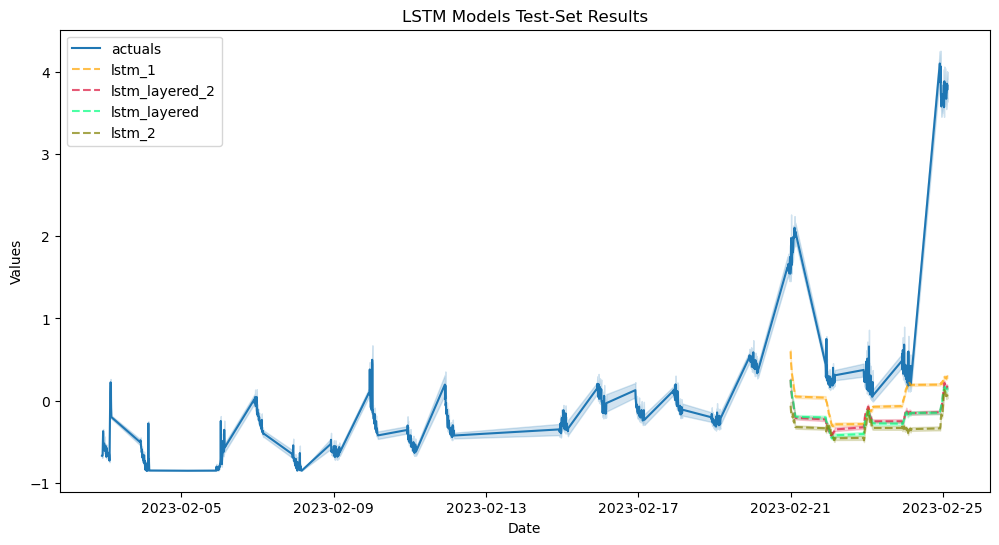

In [71]:
f.manual_forecast(
    lags=50,
    layers_struct=[('LSTM',{'units':64,'dropout':0.1})]*3 + [('Dense',{'units':10})]*2,
    epochs=15,
    random_seed=42,
    plot_loss=True,
    validation_split=0.2,
    call_me='lstm_layered_2',
    verbose=0
)
f.plot_test_set(ci=True,order_by='TestSetRMSE')
plt.title('LSTM Models Test-Set Results')
plt.show()